# Bicycles Sharing Clustering Lyon

Timeseries data about the number of bikes and bike stands for the Lyon city (France), betweek 2017-07-11 and 2017-09-26.

## Some Imports

In [76]:
%matplotlib inline

In [77]:
import numpy as np
import pandas as pd

In [78]:
from sklearn.cluster import KMeans

In [79]:
from matplotlib import pyplot as plt

In [80]:
import seaborn as sns
sns.set_context('talk')

## Which Dependencies versions

In [81]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [82]:
%watermark -d -v -p numpy,pandas,sklearn,matplotlib,seaborn -g -m -w

2017-10-23 

CPython 3.5.3
IPython 6.1.0

numpy 1.13.1
pandas 0.20.3
sklearn 0.19.0
matplotlib 2.0.2
seaborn 0.8.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)
system     : Darwin
release    : 16.7.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
Git hash   : e0ac261935cd81c45afabcdd47f46fbdb1973486
watermark 1.5.0


## Load Lyon Data

In [83]:
DATA = "./data/lyon.csv"

In [84]:
raw = pd.read_csv(DATA, parse_dates=['last_update'])

In [85]:
raw.drop_duplicates(inplace=True)

In [86]:
raw = raw.sort_values(["number", "last_update"])

In [87]:
MIN_DATE = '2017-07-11'
MAX_DATE = '2017-09-26'

## Some Cleaning

In [88]:
print(raw.shape)

(4569378, 9)


In [89]:
drop_columns = ["availability", "bonus", "status", "bike_stands", "available_bike_stands", "availabilitycode"]

In [90]:
data = (raw.copy()
        .query("last_update >= '{}' and last_update <= '{}'".format(MIN_DATE, MAX_DATE))
        .drop(drop_columns, axis=1)
        .rename_axis({"available_bikes": "bikes", "number": "station", "last_update": "ts"}, axis=1))

In [91]:
data.head()

,station,ts,bikes
199806,1001,2017-07-11 00:05:17,12
200154,1001,2017-07-11 00:12:24,13
200502,1001,2017-07-11 00:17:19,12
201198,1001,2017-07-11 00:27:23,12
201546,1001,2017-07-11 00:31:09,13


Some strange stations where the max number of bikes is 0

In [92]:
max_bikes = data.groupby("station")["bikes"].max()
max_bikes

station
1001     16
1002     23
1003     15
1005     10
1006     22
1012     20
1013     11
1016     17
1020     18
1021     11
1022     31
1023     20
1024     17
1031     20
1032     22
1034     16
1035     16
1036     17
2001     32
2002     20
2003     10
2004     18
2005     32
2006     14
2007     22
2008     18
2009     26
2010     22
2011     13
2012     16
         ..
10080    17
10083    15
10084    30
10086    10
10087    12
10088    19
10089    15
10091    16
10092    17
10101    34
10102    30
10103    30
10110    18
10111    16
10112    32
10113    22
10114    20
10115    22
10116     0
10117    22
10118    22
10119    25
10120    16
10121    16
10122    21
11001    18
11002    20
11003    20
12001    25
12002    18
Name: bikes, Length: 348, dtype: int64

In [93]:
wrong_stations = max_bikes[max_bikes == 0].index.tolist()
wrong_stations

[2026, 2035, 3010, 3032, 3090, 8020, 10021, 10025, 10116]

In [94]:
well_station_mask = np.logical_not(data['station'].isin(wrong_stations))

In [95]:
data = data[well_station_mask]
print(data.shape)

(4416849, 3)


## Time Resampling

Get data every 10 minutes

In [96]:
df = (data.set_index("ts")
      .groupby("station")["bikes"]
      .resample("10T")
      .mean()
      .bfill())

In [97]:
df.head(10)

station  ts                 
1001     2017-07-11 00:00:00    12.000000
         2017-07-11 00:10:00    12.500000
         2017-07-11 00:20:00    12.000000
         2017-07-11 00:30:00    13.000000
         2017-07-11 00:40:00    13.000000
         2017-07-11 00:50:00    13.000000
         2017-07-11 01:00:00    12.000000
         2017-07-11 01:10:00    11.000000
         2017-07-11 01:20:00    10.666667
         2017-07-11 01:30:00    10.000000
Name: bikes, dtype: float64

In [98]:
df = df.unstack(0)

In [102]:
df['hour'] = df.index.hour

In [103]:
df.head()

station,1001,1002,1003,1005,1006,1012,1013,1016,1020,1021,...,10119,10120,10121,10122,11001,11002,11003,12001,12002,hour
ts,,,,,,,,,,,,,,,,,,,,,
2017-07-11 00:00:00,12.0,6.0,15.0,1.0,4.5,19.0,10.5,3.0,1.0,1.0,...,0.0,15.0,16.0,5.0,0.0,10.0,12.0,0.0,0.0,0
2017-07-11 00:10:00,12.5,7.0,15.0,1.0,5.0,19.0,10.0,3.0,1.0,2.0,...,0.0,15.0,16.0,5.0,0.0,10.0,12.0,0.0,0.0,0
2017-07-11 00:20:00,12.0,5.5,15.0,1.0,5.0,19.0,10.0,3.0,1.0,2.0,...,0.0,15.0,16.0,5.0,0.0,10.0,12.0,0.0,0.0,0
2017-07-11 00:30:00,13.0,6.5,15.0,1.0,5.0,18.0,10.0,3.0,1.0,2.0,...,0.0,15.0,16.0,5.0,0.0,10.0,12.0,0.0,0.0,0
2017-07-11 00:40:00,13.0,8.5,15.0,1.0,5.0,18.0,10.0,3.0,1.0,3.0,...,0.0,15.0,16.0,5.0,0.0,10.0,12.0,0.0,0.0,0


In [104]:
profile = df.groupby("hour").mean()
profile.head()

station,1001,1002,1003,1005,1006,1012,1013,1016,1020,1021,...,10118,10119,10120,10121,10122,11001,11002,11003,12001,12002
hour,,,,,,,,,,,,,,,,,,,,,
0,12.095238,12.022727,8.251804,5.725469,7.784632,13.549062,7.263709,10.433622,9.532107,5.524170,...,13.767316,1.424242,11.105700,12.632395,9.186147,1.730519,11.711039,14.163420,2.810967,1.897186
1,9.803391,8.627345,7.364358,4.807720,8.012987,10.051587,6.724387,9.081890,6.038600,3.054113,...,13.981602,1.542208,12.025974,13.230519,9.337662,1.967532,12.348124,14.208874,2.048341,1.431818
2,8.153319,5.669553,6.957071,4.011183,8.014069,7.668831,5.814214,7.712843,4.313492,1.892857,...,14.230159,1.638528,12.268398,13.503247,9.462121,2.007576,12.829004,14.257937,2.513709,1.372294
3,6.759740,3.895743,6.477273,3.530664,7.915584,6.183622,5.227633,6.645382,3.146104,1.026696,...,14.338745,1.685065,12.549784,13.645382,9.587662,2.019481,13.115440,14.316017,2.933983,1.304473
4,6.299062,2.962482,5.975108,2.797980,7.762987,5.418831,4.520202,5.929654,2.536436,0.889250,...,14.313131,1.766234,12.800866,13.813853,9.649351,2.075758,13.330087,14.341991,3.641053,1.281385


## Clustering

In [129]:
n_clusters = 4

In [130]:
#df = df.fillna(method='bfill')

In [131]:
#df = df.fillna(method='ffill')

Normalization

In [132]:
df_norm = profile / profile.max()

In [133]:
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(df_norm.T)

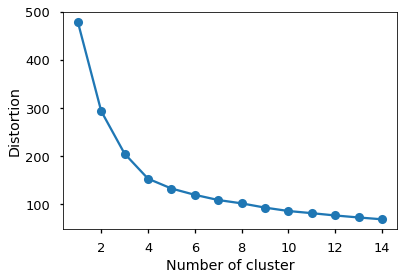

In [110]:
# On choisi 4 cluster
distortions = []
for i in range (1, 15):
    km = k_means = KMeans(random_state=0, n_clusters=i).fit(df_norm.T)
    distortions.append(km.inertia_)
plt.plot(range(1, 15), distortions, marker='o')
plt.xlabel('Number of cluster')
plt.ylabel('Distortion')
plt.show()

In [134]:
label = pd.Series(kmeans.labels_)

Number of stations for each label, i.e. usage pattern

In [135]:
label.groupby(label).count()

0     84
1    143
2     33
3     79
dtype: int64

Colors for each cluster

In [136]:
colors = sns.color_palette('Set1', n_clusters)

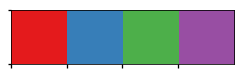

In [137]:
sns.palplot(colors)

Daily profile

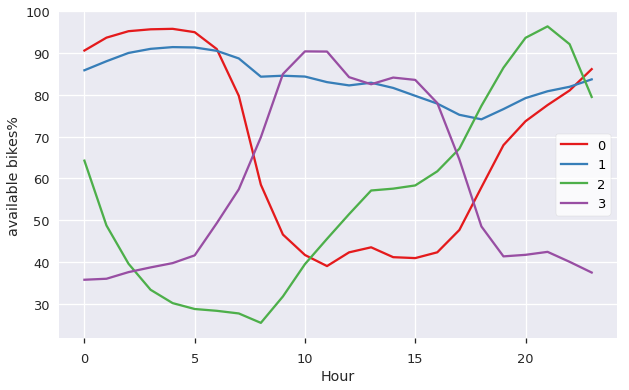

In [138]:
with sns.axes_style("darkgrid", {'xtick.major.size': 5.0}):
    fig, ax = plt.subplots(figsize=(10,6))

for k, label, color in zip(kmeans.cluster_centers_, range(n_clusters), colors):
    plt.plot(100*k, color=color, label=label)
    
plt.legend()
plt.xlabel('Hour')
plt.ylabel("available bikes%")
sns.despine()

In [142]:
len(kmeans.labels_)

339

In [143]:
 df_norm.T.shape

(339, 24)

## Extract cluster

In [144]:
cluster_station = df_norm.T
cluster_station['cluster'] = kmeans.labels_
cluster_station.reset_index(inplace=True)
cluster_station = cluster_station[['station', 'cluster']]

In [146]:
cluster_station.to_csv('data/cluster_lyon_armand.csv', index=False)

## Map

Station names and lat/lon coordinates.

In [64]:
locations = pd.read_csv("./data/lyon-stations.csv")

In [65]:
mask = np.logical_not(locations['idstation'].isin(wrong_stations))

In [66]:
locations = locations[mask]

In [67]:
locations.head()

,idstation,nom,lat,lon
0,10027,Mairie de Villeurbanne,45.766831,4.879894
1,10030,Greuze,45.773844,4.893848
2,10034,MJC,45.761788,4.886157
3,10036,Chaplin / Dutriévoz,45.774357,4.859155
4,10038,Condorcet / 11 Nov. 1918,45.779046,4.866778


In [68]:
dflabel = pd.DataFrame({"label": kmeans.labels_}, index=df.columns)

In [69]:
locations = locations.merge(dflabel, right_index=True, left_on='idstation')

In [70]:
locations.head()

,idstation,nom,lat,lon,label
0,10027,Mairie de Villeurbanne,45.766831,4.879894,2
1,10030,Greuze,45.773844,4.893848,2
2,10034,MJC,45.761788,4.886157,0
3,10036,Chaplin / Dutriévoz,45.774357,4.859155,1
4,10038,Condorcet / 11 Nov. 1918,45.779046,4.866778,1


In [71]:
locations["nom"] = locations['nom'].str.replace("'", "&apos;")

In [72]:
import folium

In [73]:
# Lyon (France) Position
position = [45.750000, 4.850000]

In [76]:
mp = folium.Map(location=position, zoom_start=13, tiles='cartodbpositron')
#mp = folium.Map(location=position, zoom_start=13)

In [74]:
hex_colors = colors.as_hex()

In [77]:
for _,row in locations.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        popup=row['nom'],
        color=hex_colors[row['label']],
        fill=True,
        fill_opacity=0.7,
        fill_color=hex_colors[row['label']]
    ).add_to(mp)

In [78]:
mp.save("lyon-map-n_clusters-{}.html".format(n_clusters))

In [79]:
mp